# Handling Missing Values



<img src="https://i.imgur.com/68u0dD2.png" width="800" >



## Import Libraries

In [4]:
# Data wrangling
import pandas as pd
import numpy as np

# Plots
import matplotlib.pyplot as plt
import seaborn as sns

# Missing values charts
import missingno as msno

# Stats
from scipy.stats import ks_2samp

# Pre
from sklearn.model_selection import train_test_split

# Metrics
from sklearn.metrics import classification_report, f1_score, roc_auc_score

# Models
from sklearn.dummy import DummyClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier


## Data Exploration

In [6]:
df = pd.read_csv("./Dataset/Diabetes Missing Data.csv")

In [7]:
df.head()

,Pregnant,Glucose,Diastolic_BP,Skin_Fold,Serum_Insulin,BMI,Diabetes_Pedigree,Age,Class
0,6,148.0,72.0,35.0,NaN,33.6,0.627,50,1
1,1,85.0,66.0,29.0,NaN,26.6,0.351,31,0
2,8,183.0,64.0,NaN,NaN,23.3,0.672,32,1
3,1,89.0,66.0,23.0,94.0,28.1,0.167,21,0
4,0,137.0,40.0,35.0,168.0,43.1,2.288,33,1


In [8]:
df.shape

(768, 9)

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Pregnant           768 non-null    int64  
 1   Glucose            763 non-null    float64
 2   Diastolic_BP       733 non-null    float64
 3   Skin_Fold          541 non-null    float64
 4   Serum_Insulin      394 non-null    float64
 5   BMI                757 non-null    float64
 6   Diabetes_Pedigree  768 non-null    float64
 7   Age                768 non-null    int64  
 8   Class              768 non-null    int64  
dtypes: float64(6), int64(3)
memory usage: 54.1 KB


A preliminary inspection reveals missing values in several key features. Specifically, `Glucose`, `Diastolic_BP`, `Skin_Fold`, `Serum_Insulin`, and `BMI` contain null values, with `Serum_Insulin` and `Skin_Fold` exhibiting the most significant data loss (374 and 227 missing entries, respectively). These missing values may impact the reliability of any predictive model trained on this data, especially considering that these features are biologically relevant for diabetes prediction.

In [11]:
df.describe()

,Pregnant,Glucose,Diastolic_BP,Skin_Fold,Serum_Insulin,BMI,Diabetes_Pedigree,Age,Class
count,768.000000,763.000000,733.000000,541.000000,394.000000,757.000000,768.000000,768.000000,768.000000
mean,3.845052,121.686763,72.405184,29.153420,155.548223,32.457464,0.471876,33.240885,0.348958
std,3.369578,30.535641,12.382158,10.476982,118.775855,6.924988,0.331329,11.760232,0.476951
min,0.000000,44.000000,24.000000,7.000000,14.000000,18.200000,0.078000,21.000000,0.000000
25%,1.000000,99.000000,64.000000,22.000000,76.250000,27.500000,0.243750,24.000000,0.000000
50%,3.000000,117.000000,72.000000,29.000000,125.000000,32.300000,0.372500,29.000000,0.000000
75%,6.000000,141.000000,80.000000,36.000000,190.000000,36.600000,0.626250,41.000000,1.000000
max,17.000000,199.000000,122.000000,99.000000,846.000000,67.100000,2.420000,81.000000,1.000000


The high standard deviation in variables like `Serum_Insulin` and `Skin_Fold` suggests substantial variability.

In [13]:
df.isna().sum() / len(df) * 100 # Percentaje of Missing Values

Pregnant              0.000000
Glucose               0.651042
Diastolic_BP          4.557292
Skin_Fold            29.557292
Serum_Insulin        48.697917
BMI                   1.432292
Diabetes_Pedigree     0.000000
Age                   0.000000
Class                 0.000000
dtype: float64

The percentage of missing values confirms that missingness is a substantial issue in the dataset. This level of missingness may significantly influence the effectiveness of machine learning models and demands careful treatment. 

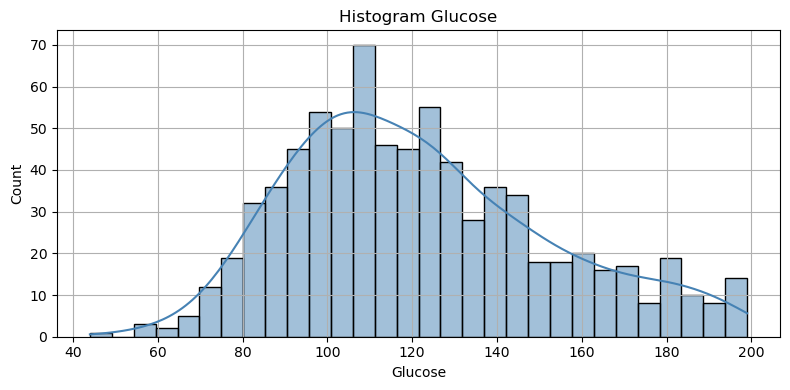

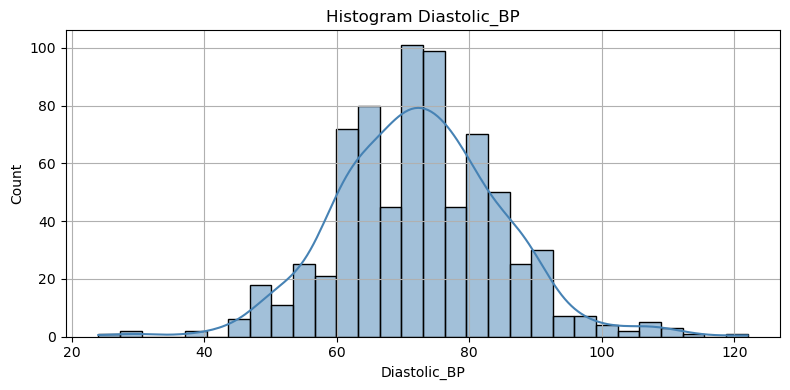

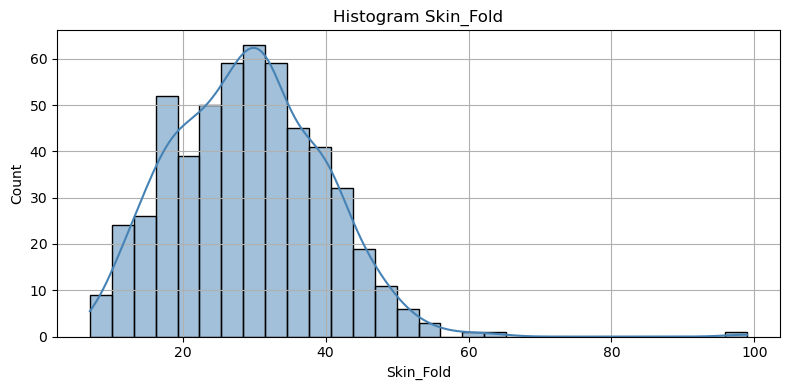

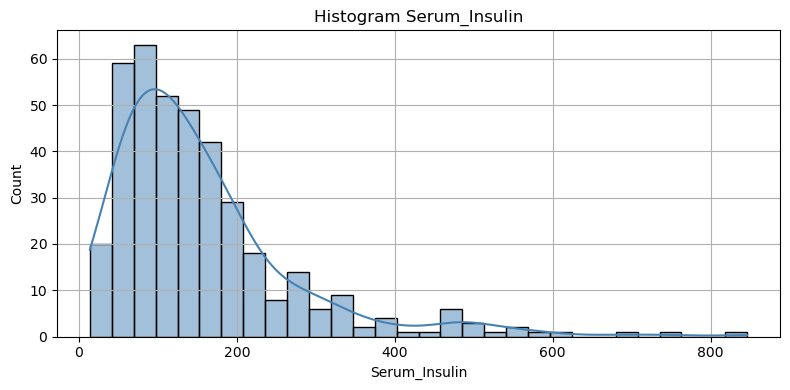

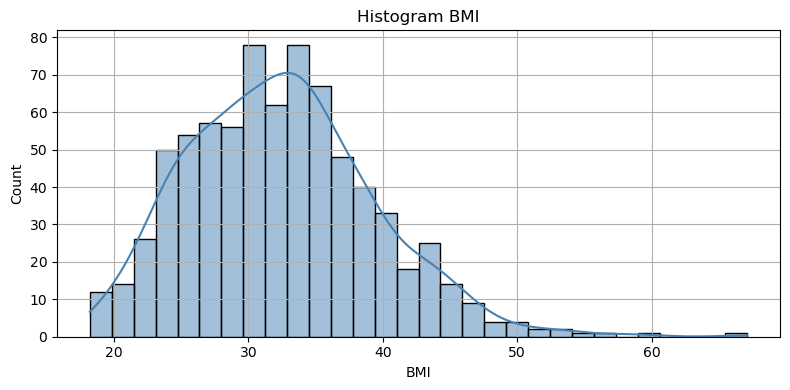

In [15]:
# Distributions of Columns with Missing Values

for column in df.columns:
    if df[column].isna().sum() > 0:
        plt.figure(figsize=(8, 4))
        sns.histplot(df[column].dropna(), kde=True, bins=30, color='steelblue')
        plt.title(f'Histogram {column}')
        plt.xlabel(column)
        plt.grid(True)
        plt.tight_layout()
        plt.show()

The histograms reveal distinct distribution patterns across the variables with missing data, which has important implications for selecting appropriate imputation strategies. `Glucose` and `BMI` exhibit right-skewed distributions, with most values concentrated around the mid-ranges and long tails extending toward higher values. `Diastolic_BP` appears roughly normally distributed, suggesting that simple imputations like mean or median could be suitable here. `Skin_Fold` and `Serum_Insulin`, however, are highly right-skewed with substantial variability, indicating that imputing missing values using the mean may lead to biased results.

### Missing Values Exploration

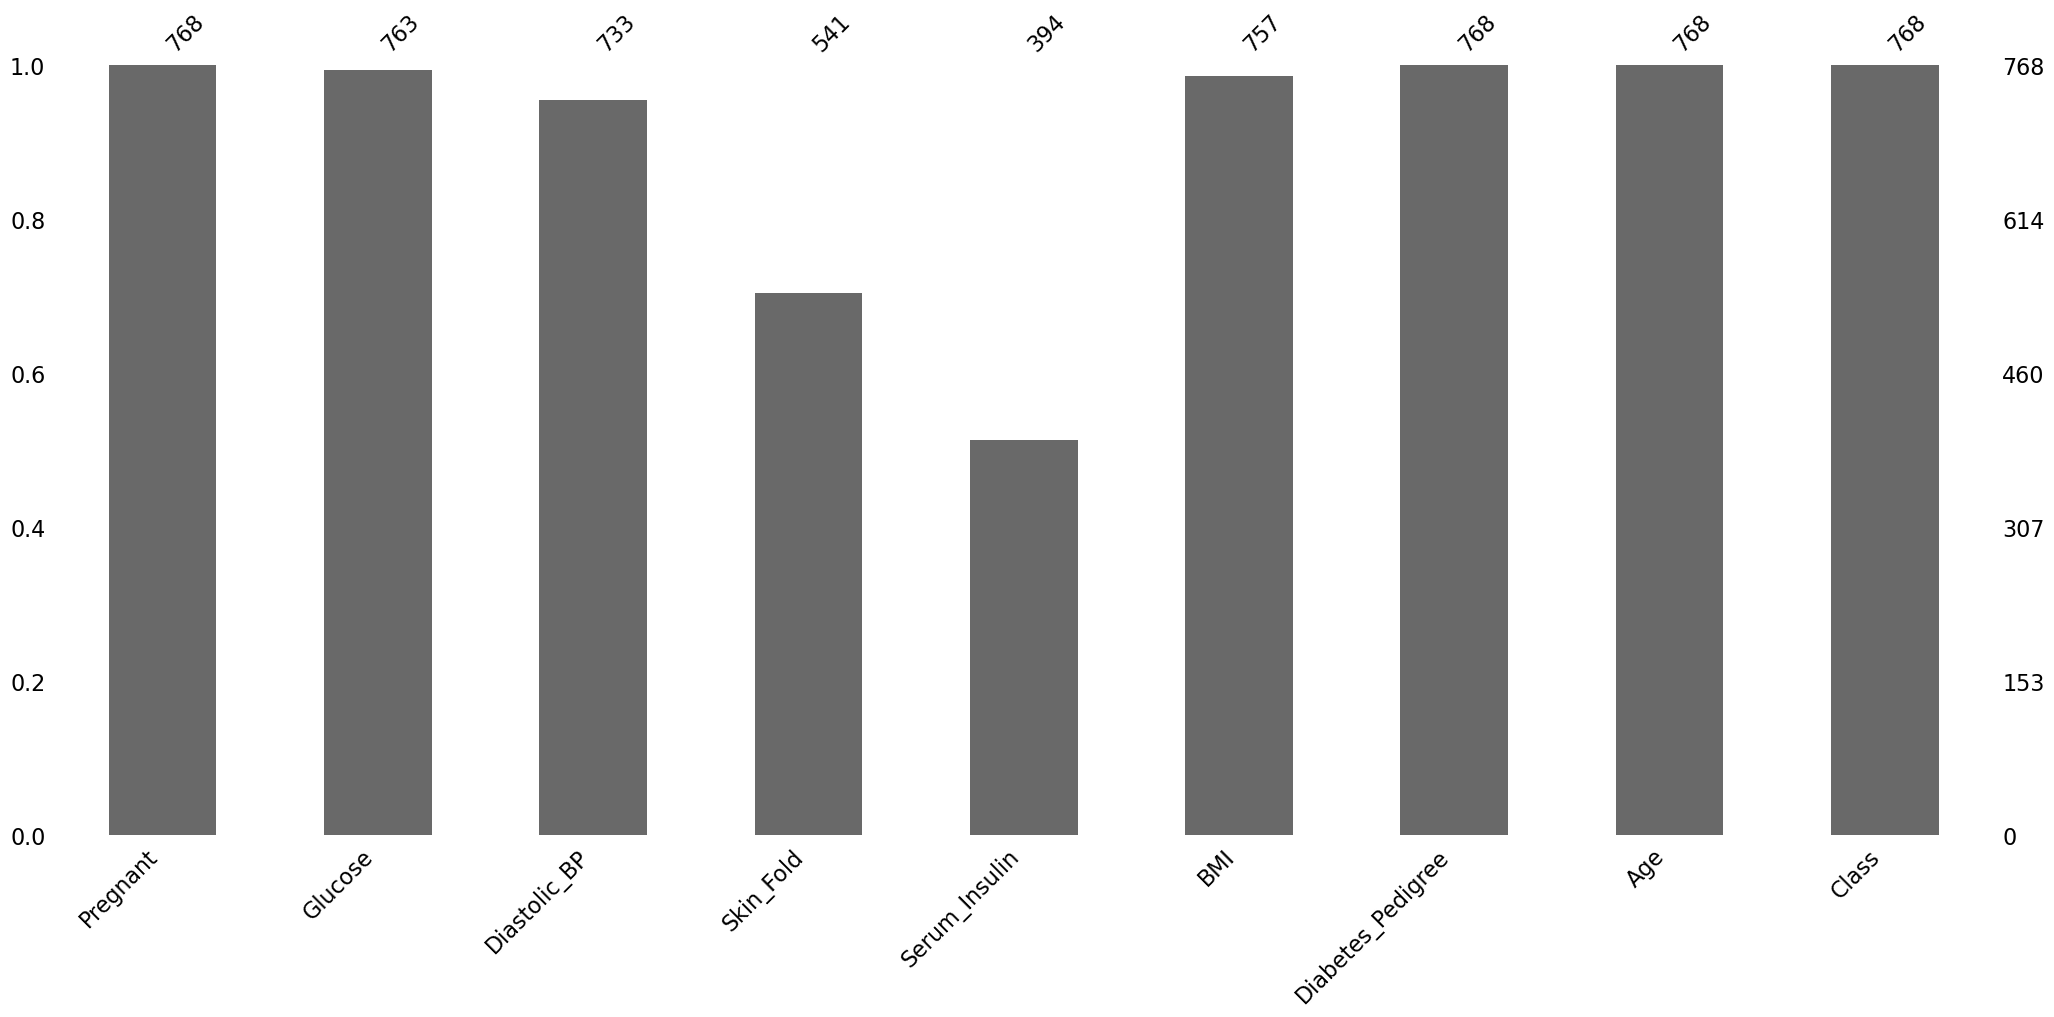

In [18]:
msno.bar(df)
plt.show()

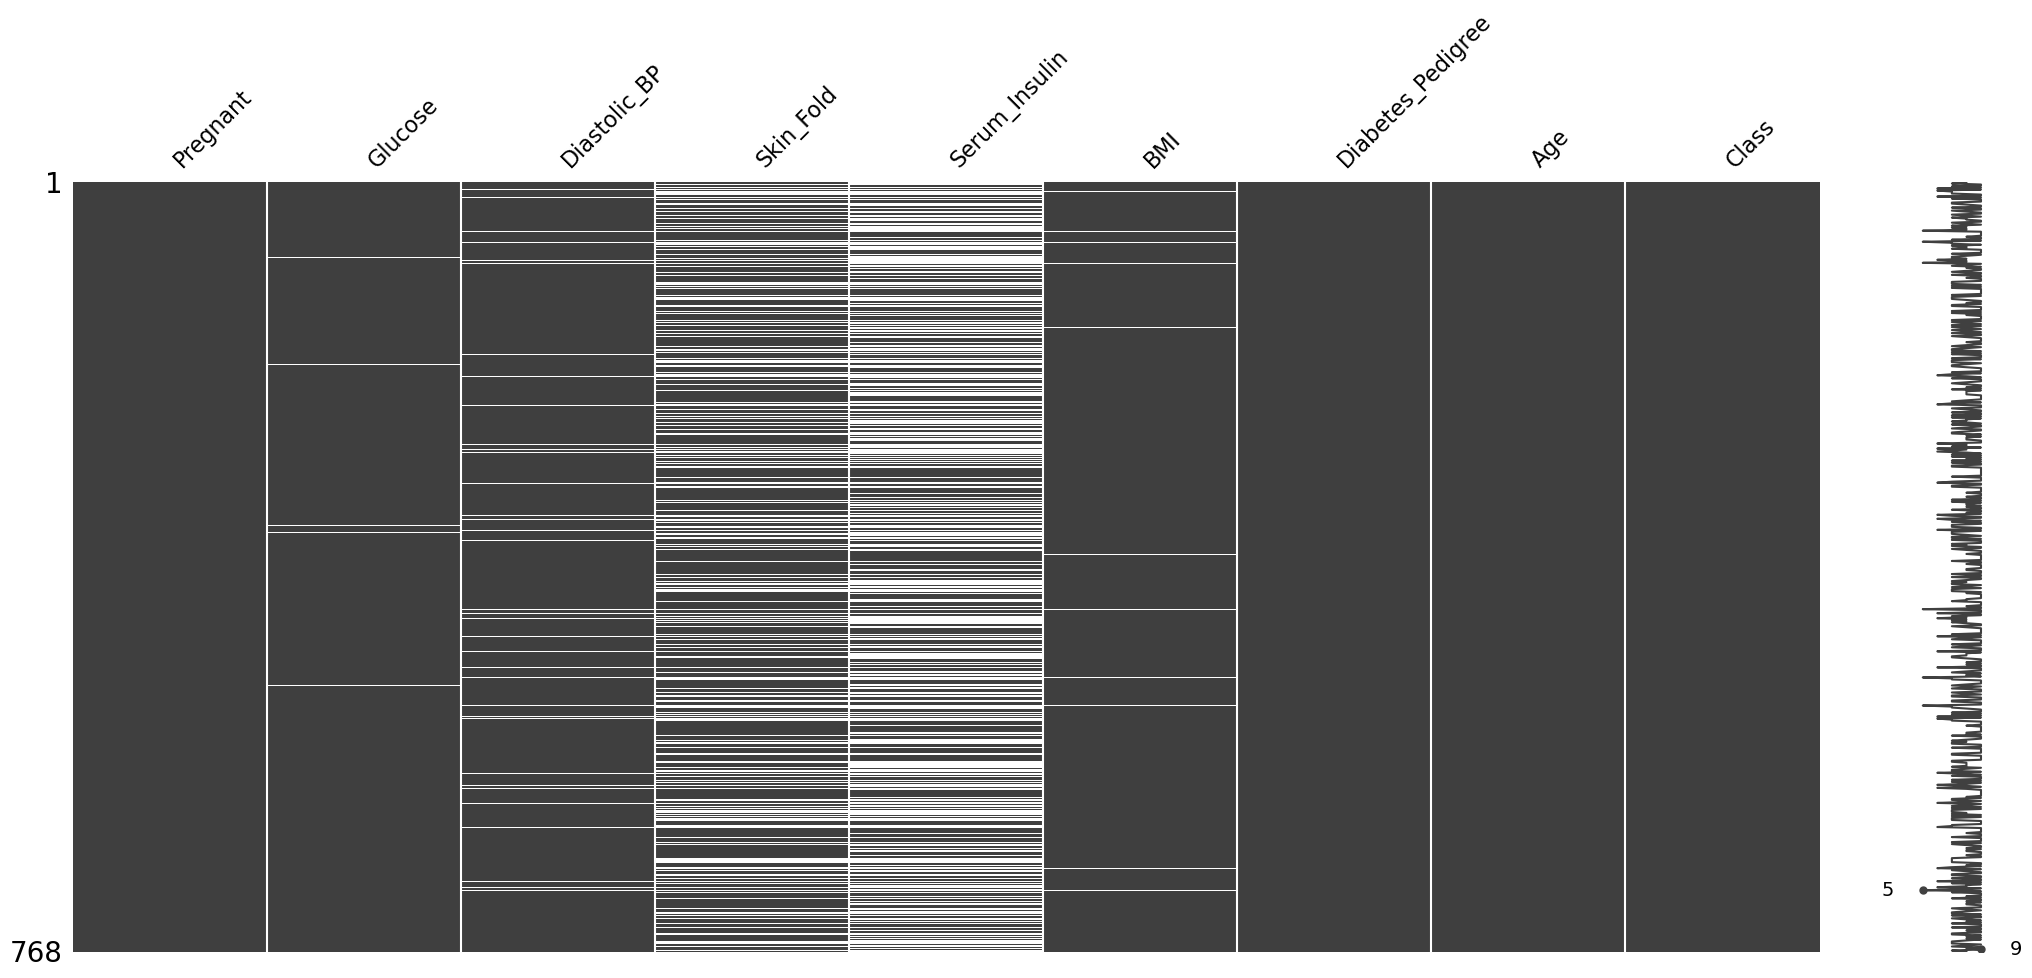

In [19]:
msno.matrix(df) 
plt.show()

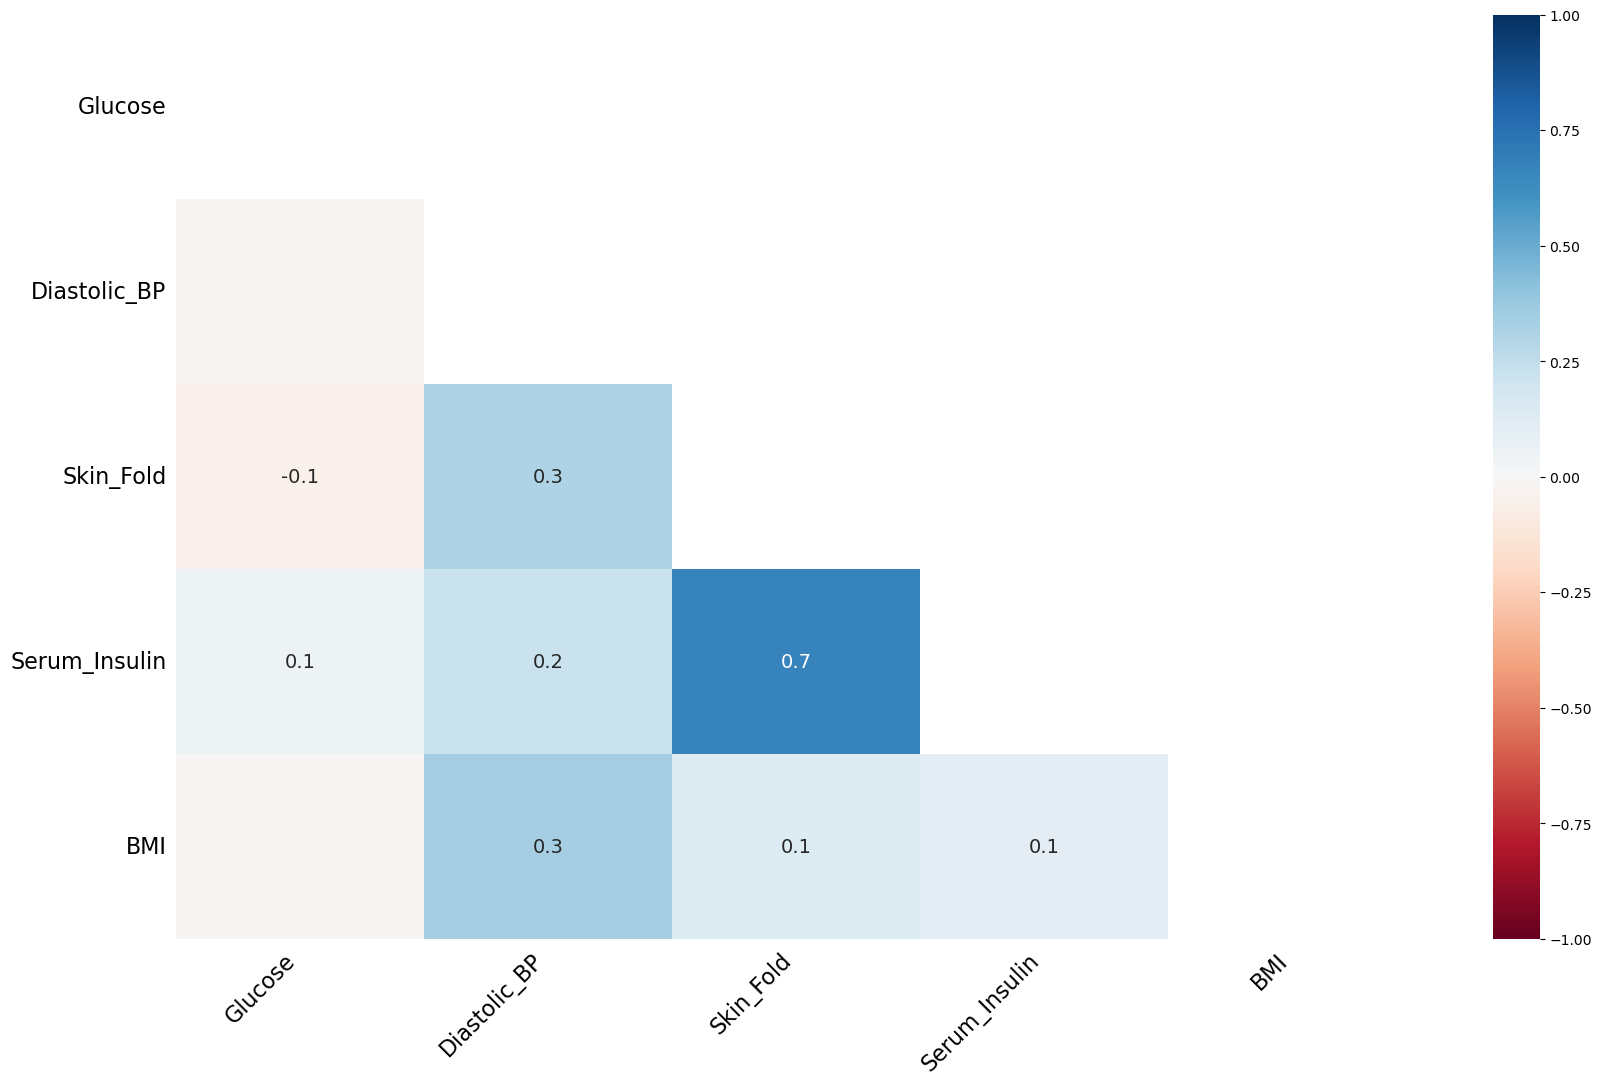

In [20]:
msno.heatmap(df)
plt.show()

serum_insulin and skin_fold are related

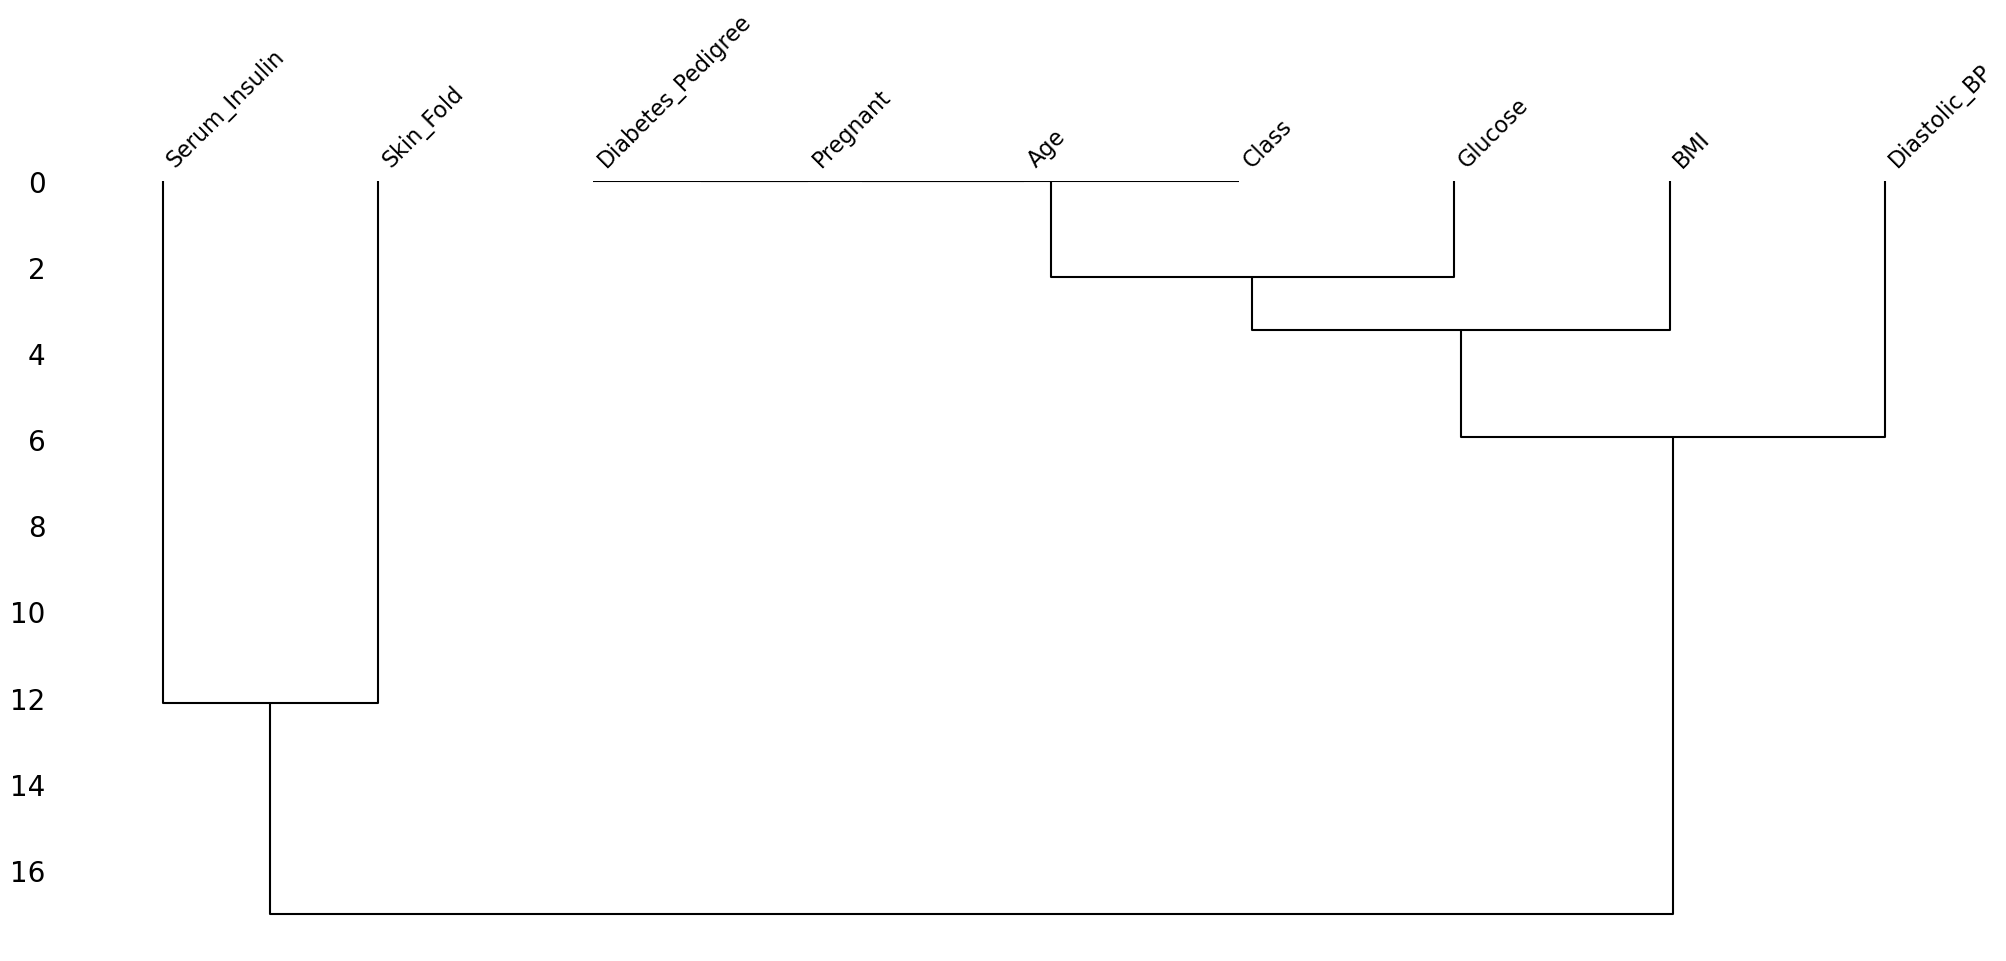

In [22]:
msno.dendrogram(df)
plt.show()

The strongest correlation is observed between `Serum_Insulin` and `Skin_Fold`, suggesting that these two features share a significant amount of information and can potentially be used to impute one another using regression or multivariate techniques. Other correlations, such as between `BMI` and `Diastolic_BP`, are moderate, while most other pairwise relationships are weak. The dendrogram supports this finding, clustering `Serum_Insulin` and `Skin_Fold closely` together, indicating their similarity in data structure. 

### MCAR, MAR and MNAR

In [25]:
df_missing = df.copy()

In [26]:
columns = ['Pregnant',
 'Glucose',
 'Diastolic_BP',
 'Skin_Fold',
 'Serum_Insulin',
 'BMI',
 'Diabetes_Pedigree',
 'Age']

missing_columns = ['Glucose',
 'Diastolic_BP',
 'Skin_Fold',
 'Serum_Insulin',
 'BMI']

In [81]:
def ks_2samp_test(df, value, columns):
    df['missing_values'] = df[value].isnull().astype(int)
    print(value.upper())

    for column in columns:
        if value != column:
            group1 = df[df['missing_values'] == 1][column].dropna()
            group2 = df[df['missing_values'] == 0][column].dropna()

            if len(group1) > 1 and len(group2) > 1:
                result = ks_2samp(group1, group2)

                if result.pvalue < 0.05:
                    print(f"{column} affects {value}")
                else:
                    print(f"{column} does not affect {value}")
            else:
                print(f"{column} has insufficient data to test against {value}")

    print("-----------------------------------")


In [83]:
for value in missing_columns:
    ks_2samp_test(df_missing, value, columns)

GLUCOSE
Pregnant does not affect Glucose
Diastolic_BP does not affect Glucose
Skin_Fold does not affect Glucose
Serum_Insulin has insufficient data to test against Glucose
BMI does not affect Glucose
Diabetes_Pedigree does not affect Glucose
Age does not affect Glucose
-----------------------------------
DIASTOLIC_BP
Pregnant does not affect Diastolic_BP
Glucose does not affect Diastolic_BP
Skin_Fold does not affect Diastolic_BP
Serum_Insulin has insufficient data to test against Diastolic_BP
BMI does not affect Diastolic_BP
Diabetes_Pedigree does not affect Diastolic_BP
Age does not affect Diastolic_BP
-----------------------------------
SKIN_FOLD
Pregnant affects Skin_Fold
Glucose affects Skin_Fold
Diastolic_BP affects Skin_Fold
Serum_Insulin has insufficient data to test against Skin_Fold
BMI affects Skin_Fold
Diabetes_Pedigree affects Skin_Fold
Age affects Skin_Fold
-----------------------------------
SERUM_INSULIN
Pregnant affects Serum_Insulin
Glucose does not affect Serum_Insuli

In [85]:
def ks_test_matrix(df, missing_columns, test_columns):
    results = pd.DataFrame(index=test_columns, columns=missing_columns)

    for missing_col in missing_columns:
        df['missing_values'] = df[missing_col].isnull().astype(int)

        for col in test_columns:
            if col == missing_col:
                results.loc[col, missing_col] = None
                continue

            group1 = df[df['missing_values'] == 1][col].dropna()
            group2 = df[df['missing_values'] == 0][col].dropna()

            if len(group1) > 1 and len(group2) > 1:
                stat = ks_2samp(group1, group2)
                results.loc[col, missing_col] = stat.pvalue
            else:
                results.loc[col, missing_col] = None

    return results.astype(float)

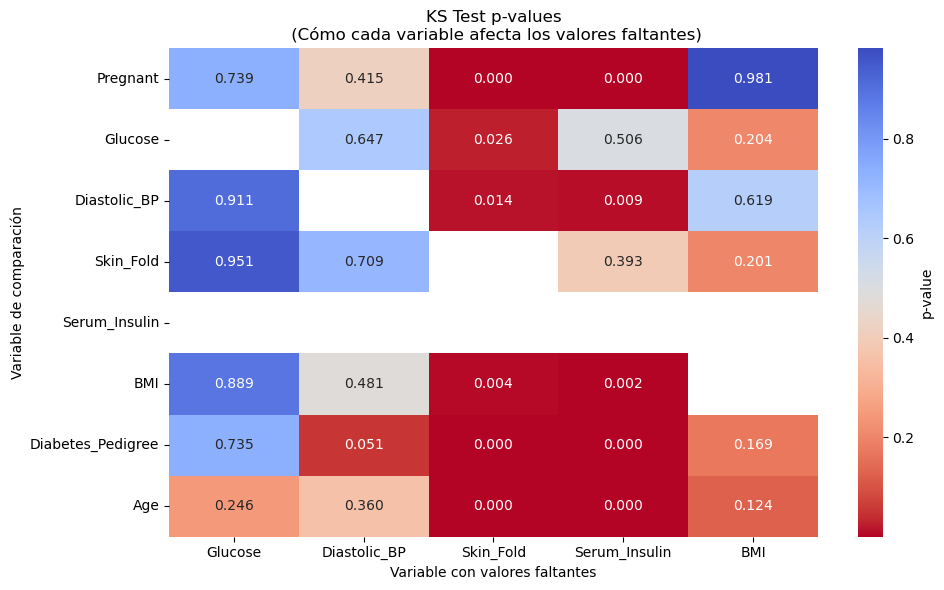

In [89]:
ks_pvalues = ks_test_matrix(df.copy(), missing_columns, columns)

# Visualiza con mapa de calor
plt.figure(figsize=(10, 6))
sns.heatmap(ks_pvalues, annot=True, fmt=".3f", cmap="coolwarm_r", cbar_kws={'label': 'p-value'})
plt.title("KS Test p-values\n (Cómo cada variable afecta los valores faltantes)")
plt.xlabel("Variable con valores faltantes")
plt.ylabel("Variable de comparación")
plt.tight_layout()
plt.show()

## Techniques

In [ ]:
# Class balance

df["Class"].value_counts() / len(df) * 100

In [ ]:
def classification_models(X, y):
   
    # Stratified Split
    X_train, X_test, y_train, y_test = train_test_split(X, y, stratify = y, random_state = 42, test_size = 0.25)

    # Models
    models = {"Dummy Stratified": DummyClassifier(strategy = "stratified", random_state = 42),
              "Random Forest": RandomForestClassifier(class_weight = "balanced", random_state = 42),
              "Logistic Regression": LogisticRegression(class_weight = "balanced", max_iter=1000, random_state = 42),
              "XGBoost": XGBClassifier(scale_pos_weight = (y == 0).sum() / (y == 1).sum(), eval_metric = "logloss", random_state = 42)}

    values = []

    for name, model in models.items():
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        
        # Prob
        try:
            y_prob = model.predict_proba(X_test)[:, 1]
            auc = roc_auc_score(y_test, y_prob)
        except:
            auc = None
        
        f1 = f1_score(y_test, y_pred)

        values.append({
            "Model": name,
            "F1-Score": round(f1, 3),
            "ROC AUC": round(auc, 3) if auc is not None else "N/A"
        })

    return pd.DataFrame(values).sort_values(by = "F1-Score", ascending = False).reset_index(drop = True)

In [ ]:
# Distributions Comparison

def plot_comparison_histograms(before_df, after_df):
    

    for column in before_df.columns:
        
        if before_df[column].isna().sum() > 0:
            
            plt.figure(figsize=(12, 4))
    

            # Original Dataset Histogram
            sns.histplot(before_df[column].dropna(), kde = True, bins = 30, color = "salmon", label = "Before", stat = "density", alpha = 0.5)
     
            # Histogram with processed data
            sns.histplot(after_df[column].dropna(), kde = True, bins = 30, color = "steelblue", label = "After", stat = "density", alpha = 0.5)
    
            plt.title(f'Distribution de {column}: Before vs After')
            plt.xlabel(column)
            plt.ylabel('Density')
            plt.grid(True)
            plt.legend()
            plt.tight_layout()
            plt.show()

### Drop Values

In [ ]:
df_1 = df.copy()

In [ ]:
df_1.dropna(inplace = True)

In [ ]:
df_1.shape

In [ ]:
plot_comparison_histograms(df, df_1)

In [ ]:
df_1.isna().sum() / len(df_1) * 100

In [ ]:
X_1 = df_1.drop(columns = "Class")
y_1 = df_1["Class"]
classification_models(X_1, y_1)

### Media

In [ ]:
df_2 = df.copy()

In [ ]:
df_2

In [ ]:
df_2.describe()

In [ ]:
df_2 = df_2.fillna(df_2.mean())

In [ ]:
df_2.describe()

In [ ]:
plot_comparison_histograms(df, df_2)

In [ ]:
X_2 = df_2.drop(columns = "Class")
y_2 = df_2["Class"]
classification_models(X_2, y_2)

### Median

In [ ]:
df_3 = df.copy()

In [ ]:
df_3.head()

In [ ]:
df_3.describe()

In [ ]:
df_3 = df_3.fillna(df_3.median())

In [ ]:
df_3.describe()

In [ ]:
df_3.head()

In [ ]:
plot_comparison_histograms(df, df_3)

In [ ]:
X_3 = df_3.drop(columns = "Class")
y_3 = df_3["Class"]
classification_models(X_3, y_3)

In [ ]:
sns.regplot(data = df, x = "Skin_Fold", y = "Serum_Insulin")

In [ ]:
df[["Skin_Fold", "Serum_Insulin"]].corr()

### Delete Columns + Media

### Delete Columns + Median

### KNN Imputer

### MICE

## Analysis and Conclusion